-----
```
# Just press this button to start the step.
```
-----
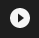
-----
```
# The green check mark means the step is done.
```
-----
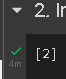
-----
```
# You will get a link similar to this image below, click it to go to the generator.
```
-----
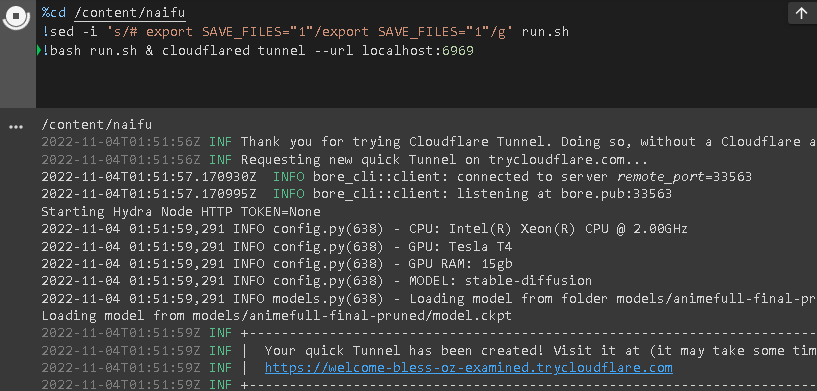
-----


In [ ]:
#@title ### 1. Install Files
#@markdown When this step is done (green check mark), look towards your left (<-) and you will
#@markdown see a folder icon, click/press it, then press the 'naifu' folder,
#@markdown when you press it you will see a list of files, double-click/open
#@markdown requirements.txt and change the "pytorch_lightning" to "pytorch_lightning==1.7.7" after that just close it.

#@markdown You may proceed to the next step.

%cd /content/
!apt install -y -qq aria2
!aria2c --summary-interval=5 -x 3 --allow-overwrite=true -Z \
   https://pub-2fdef7a2969f43289c42ac5ae3412fd4.r2.dev/naifu.tar \
   https://pub-2fdef7a2969f43289c42ac5ae3412fd4.r2.dev/animefull-latest.tar
  
!echo "Decompressing..."
!tar xf naifu.tar && rm naifu.tar
!echo "Done."

In [ ]:
#@title ### 2. Install Dependencies

#@markdown Proceed to step 3 when this is done. (Green check mark.)

%cd /content/naifu
!pip install virtualenv && bash ./setup.sh
!curl -Ls https://github.com/ekzhang/bore/releases/download/v0.4.0/bore-v0.4.0-x86_64-unknown-linux-musl.tar.gz | tar zx -C /usr/bin
!curl -Lo /usr/bin/cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 && chmod +x /usr/bin/cloudflared

In [ ]:
#@title ### 3. Setup Generator and Link
#@markdown On Step 3, it will give you a randomly generated Cloudflare link- this will lead you to the emulated NAI Image Generator that will last until you run out of free google GPU instances or about 50-80 generates.

#@markdown (Note: Be sure to wait until you see something like https://0.0.0.0:6969/ before clicking Cloudflare link.)

#@markdown Do not close the tab when you want to use the generator.
%cd /content/naifu
!sed -i 's/# export SAVE_FILES="1"/export SAVE_FILES="1"/g' run.sh
!bash run.sh & cloudflared tunnel --url localhost:6969

